In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.1 MB/s eta 0:00:00


In [ ]:
#!unzip /content/drive/MyDrive/handcrafted_image_classification/dataset_full.zip -d /content/drive/MyDrive/handcrafted_image_classification

In [ ]:
import os
import io
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras import Model
from efficientnet.keras import EfficientNetB2
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D

import warnings
warnings.filterwarnings('ignore')

In [ ]:
image_size=128
default_image_size = tuple((128, 128))
labels = os.listdir('/content/drive/MyDrive/handcrafted_image_classification/dataset_full')
directory_root = '/content/drive/MyDrive/handcrafted_image_classification/dataset_full'
classes = len(labels)

In [ ]:
def image_array(dir):
    try:
        img = cv2.imread(dir)
        if img is not None :
            img = cv2.resize(img, default_image_size)
            return img_to_array(img)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
# image loading
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for disease_folder in root_dir :
        plant_disease_folder_list = listdir(f"/content/drive/MyDrive/handcrafted_image_classification/dataset_full")

    for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

    for  plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing { plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{ plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:500]:   #loading 500 image from each class
                image_directory = f"{directory_root}/{ plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".png") == True or image_directory.endswith(".PNG") == True:
                    image_list.append(image_array(image_directory))
                    label_list.append( plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Forest ...
[INFO] Processing Glacier ...
[INFO] Processing Mountains ...
[INFO] Processing Sea ...
[INFO] Processing Streets ...
[INFO] Processing Building ...
[INFO] Image loading completed


In [ ]:
X = image_list
Y = label_list

In [ ]:
X = np.array(X)

In [ ]:
X, Y = shuffle(X, Y)
print(X.shape)

(3000, 128, 128, 3)


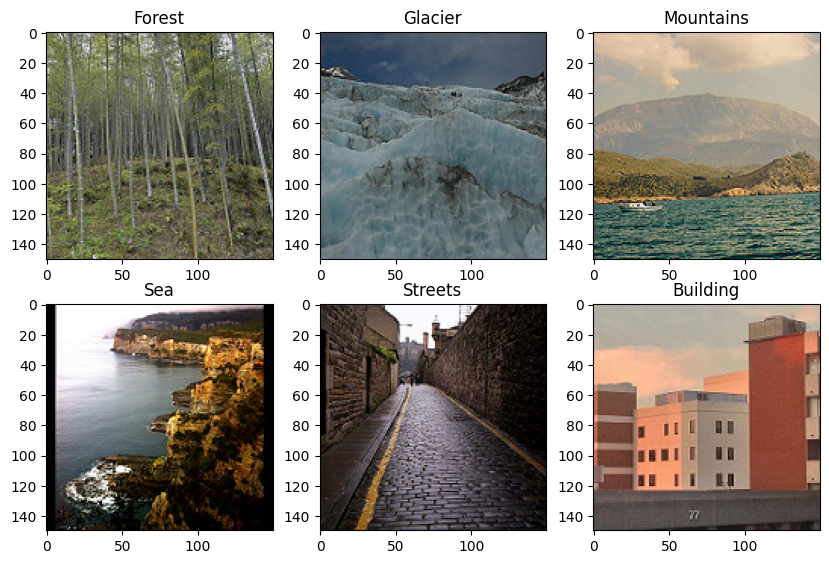

In [ ]:

#Data Visualization
import matplotlib.image as mpimg
plt.figure(figsize = (10, 10))
image_count = 1
BASE_URL = '/content/drive/MyDrive/handcrafted_image_classification/dataset_full/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(3, 3, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory)


<Axes: ylabel='count'>

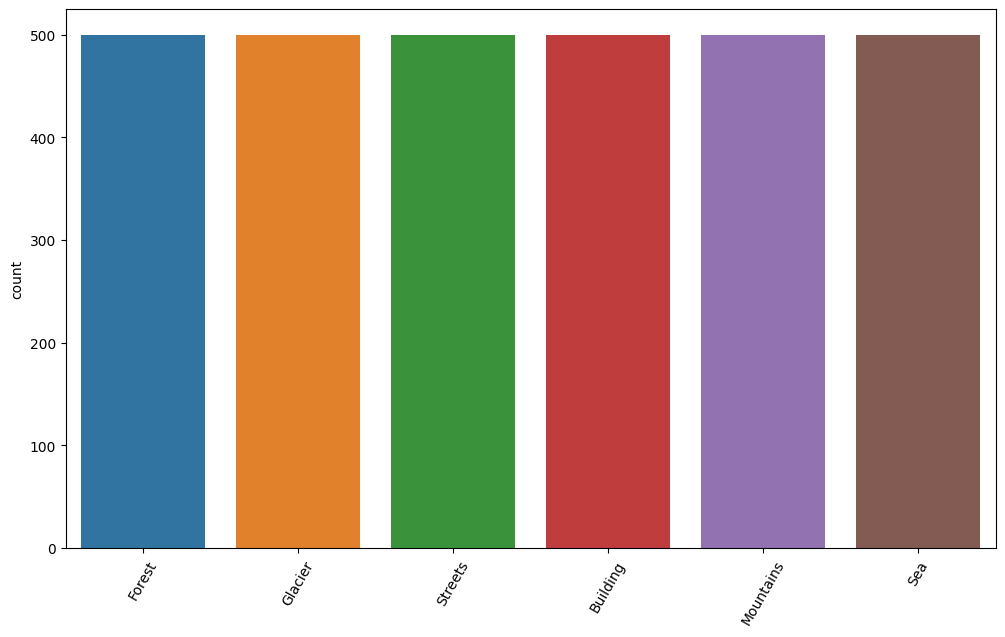

In [ ]:
#count plot
plt.figure(figsize = (12, 7))
plt.xticks(rotation=60)
sns.countplot(x=Y, hue=Y)

In [ ]:
class_labels = LabelBinarizer()
Y = class_labels.fit_transform(Y)
pickle.dump(class_labels,open('/content/drive/MyDrive/handcrafted_image_classification/label_transform.pkl', 'wb'))
n_classes = len(class_labels.classes_)

In [ ]:
cls = len(class_labels.classes_)
print(class_labels.classes_)

['Building' 'Forest' 'Glacier' 'Mountains' 'Sea' 'Streets']


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train)

# EfficientNetB2

In [ ]:
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

31936256/31936256 [==============================] - 0s 0us/step


In [ ]:
model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Dense(cls, activation='softmax')(model)
model = Model(inputs = base_model.input, outputs=model)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer= "adam", metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 64, 64, 32)           128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 64, 64, 32)           0         ['stem_bn[0][0]']         

In [ ]:
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
38/38 [==============================] - 88s 394ms/step - loss: 0.5556 - accuracy: 0.8033 - val_loss: 3.1004 - val_accuracy: 0.2815
Epoch 2/10
38/38 [==============================] - 9s 234ms/step - loss: 0.1859 - accuracy: 0.9416 - val_loss: 1.2995 - val_accuracy: 0.6593
Epoch 3/10
38/38 [==============================] - 9s 236ms/step - loss: 0.1139 - accuracy: 0.9613 - val_loss: 0.9138 - val_accuracy: 0.8185
Epoch 4/10
38/38 [==============================] - 9s 238ms/step - loss: 0.0564 - accuracy: 0.9827 - val_loss: 0.3663 - val_accuracy: 0.9111
Epoch 5/10
38/38 [==============================] - 9s 239ms/step - loss: 0.0619 - accuracy: 0.9811 - val_loss: 0.6742 - val_accuracy: 0.8815
Epoch 6/10
38/38 [==============================] - 9s 241ms/step - loss: 0.1057 - accuracy: 0.9691 - val_loss: 0.5299 - val_accuracy: 0.8926
Epoch 7/10
38/38 [==============================] - 9s 241ms/step - loss: 0.0810 - accuracy: 0.9778 - val_loss: 0.9396 - val_accuracy: 0.7926
Epoch

In [ ]:
model.save("/content/drive/MyDrive/handcrafted_image_classification/model/EfficientNetB2.h5")

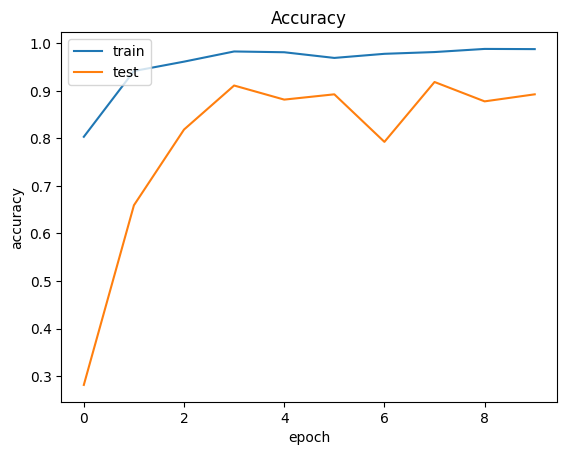

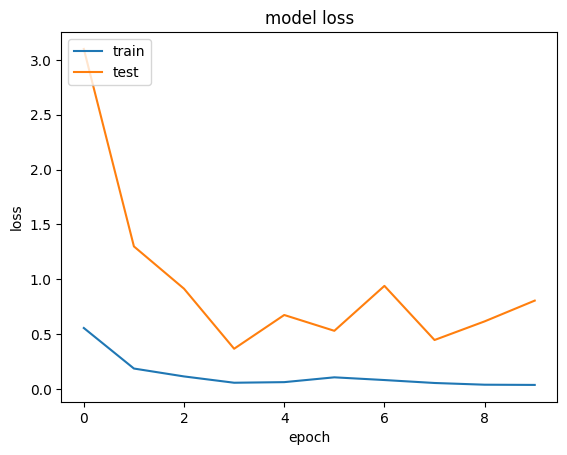

In [ ]:
#accuracy and loss plot

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

10/10 [==============================] - 4s 146ms/step


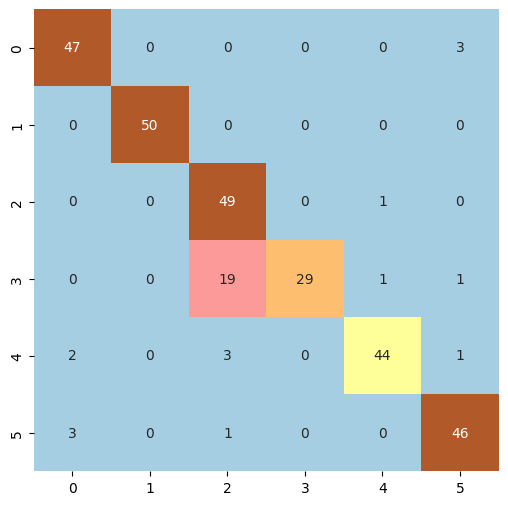

In [ ]:
cmat = confusion_matrix(y_test_new,pred)
plt.figure(figsize=(6,6))
sns.heatmap(cmat, annot = True, cbar = False, cmap='Paired', fmt="d");

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92        50
           1       1.00      1.00      1.00        50
           2       0.68      0.98      0.80        50
           3       1.00      0.58      0.73        50
           4       0.96      0.88      0.92        50
           5       0.90      0.92      0.91        50

    accuracy                           0.88       300
   macro avg       0.91      0.88      0.88       300
weighted avg       0.91      0.88      0.88       300

